### working with Raster data

In [2]:
!pip install planetary_computer

  Obtaining dependency information for planetary_computer from https://files.pythonhosted.org/packages/4f/7a/3965a2b58d172e106c1064af19707d29f86a0142c28ff40185490a0a8cfe/planetary_computer-1.0.0-py3-none-any.whl.metadata
  Using cached planetary_computer-1.0.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached python_dotenv-1.0.0-py3-none-any.whl (19 kB)
  Using cached jsonschema-4.17.3-py3-none-any.whl (90 kB)
  Obtaining dependency information for pyrsistent!=0.17.0,!=0.17.1,!=0.17.2,>=0.14.0 from https://files.pythonhosted.org/packages/a1/94/9808e8c9271424120289b9028a657da336ad7e43da0647f62e4f6011d19b/pyrsistent-0.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
Using cached planetary_computer-1.0.0-py3-none-any.whl (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 2.0 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.19.0
    Uninstalling jsonschema-4.19.0:
      Successfully uninstall

In [4]:
# load the libraries and packages

# based on examples from
# https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/
# https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook

from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import glob
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import re
import datetime
import pandas as pd
from shapely.geometry import box
import odc.stac
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio
import geopandas as gpd
import stackstac

<Axes: >

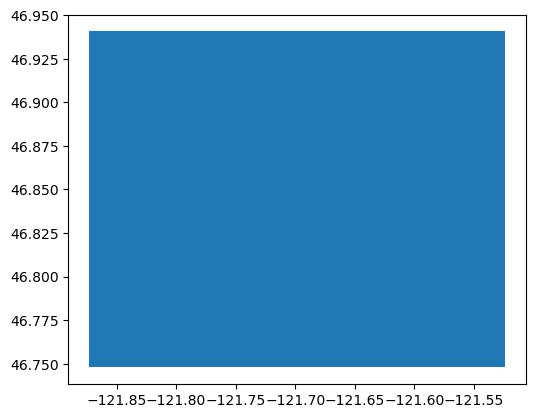

In [5]:
# set a bbox - slick way to get: https://geojson.io
# draw box around areas, save top left, save as GEOjson to a file and drag into cryocloud

bounds_latlong = gpd.read_file("shapefileTEST.geojson")
bounds_latlong.plot()

# to import a shapefiles use same code, store in subfolder

In [10]:
# pull a DEM from Microsoft Planetary Computer
catalog = pystac_client.Client.open(
"https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["cop-dem-glo-30"],
    bbox=bounds_latlong.total_bounds) # call my shapefile, total bounds passes in max min lat long

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 1 Items


In [11]:
# squeeze says don't worry about specially considering 1D bands
# items
dem_raster = stackstac.stack(items).squeeze() 

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [12]:
# Take a look
dem_raster # resolution is in units of lat long

<xarray.DataArray 'stackstac-07807c8c566bbf3e486ec0cd36b9451f' (y: 3601, x: 3601)>
dask.array<getitem, shape=(3601, 3601), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2021-04-22
    id              <U40 'Copernicus_DSM_COG_10_N46_00_W122_00_DEM'
    band            <U4 'data'
  * x               (x) float64 -122.0 -122.0 -122.0 ... -121.0 -121.0 -121.0
  * y               (y) float64 47.0 47.0 47.0 47.0 47.0 ... 46.0 46.0 46.0 46.0
    proj:epsg       int64 4326
    proj:shape      object {3600}
    platform        <U8 'TanDEM-X'
    proj:transform  object {0.0, -0.0002777777777777778, -122.00013888888888,...
    gsd             int64 30
    title           <U14 'N46_00_W122_00'
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-122.00027777777778, 46.0, -12...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-122.00|\n| 0.00,-0.00, 47.00|\n| 0.00, 0.00, 1...
    resolution:  0.0002777777777777778

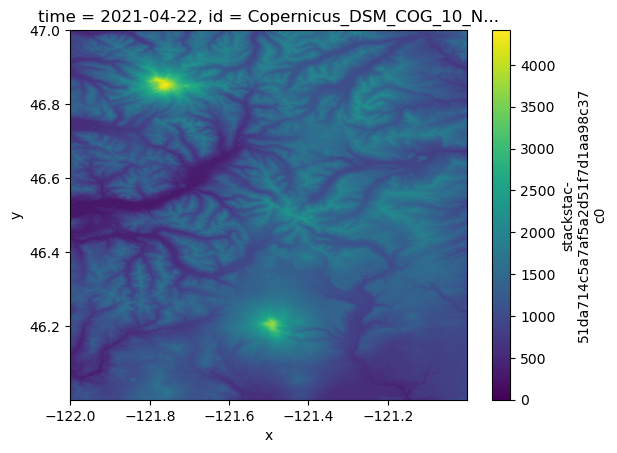

In [27]:
dem_raster.plot() #vmin within plot() sets lower level of color bar

In [21]:
bounds_latlong # geopandas geo dataframe - needs a geometry object

,geometry
0,"POLYGON ((-121.87284 46.94066, -121.87284 46.7..."


In [22]:
bounds_latlong.geometry # diff type of object

0    POLYGON ((-121.87284 46.94066, -121.87284 46.7...
Name: geometry, dtype: geometry

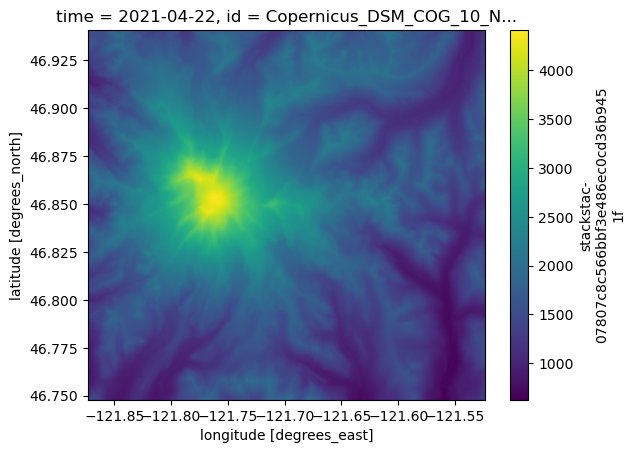

In [23]:
# Crop the large raster to the specific area of interest
dem_rainier = dem_raster.rio.clip(bounds_latlong.geometry)
dem_rainier.plot() # and plot it

In [143]:
# extract raster values for specific lat/long
# create the dataframe
#long = [-121.8, -121.6]
#lat = [46.86, 46.77]
#pts_geom = gpd.points_from_xy(x = long, y = lat)
#pts = gpd.GeoDataFrame(geometry = pts_geom, crs = "EPSG:4326") #assign CRS
#pts['Elev'] = dem_rainier.sel(x = pts_geom.x, y = pts_geom.y, method = "nearest")

In [30]:
# define points
points_geoms = gpd.points_from_xy(x = [-121.8, -121.6, -121.65],
                                 y = [46.86, 46.77, 46.9])
points_geoms

<GeometryArray>
[<POINT (-121.8 46.86)>, <POINT (-121.6 46.77)>, <POINT (-121.65 46.9)>]
Length: 3, dtype: geometry

In [31]:
# extract elevation values to a points dataframe
points = gpd.GeoDataFrame(geometry = points_geoms, crs = 'EPSG:4326')
points['x'] = points_geoms.x
points['y'] = points_geoms.y
points['Elev_m'] = dem_rainier.sel(x=xr.DataArray(points_geoms.x, dims="points"), y=xr.DataArray(points_geoms.y, dims="points"), method='nearest')
points

,geometry,x,y,Elev_m
0,POINT (-121.80000 46.86000),-121.80,46.86,3305.673584
1,POINT (-121.60000 46.77000),-121.60,46.77,1377.102539
2,POINT (-121.65000 46.90000),-121.65,46.90,1329.551514


<Axes: title={'center': 'time = 2021-04-22, id = Copernicus_DSM_COG_10_N...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

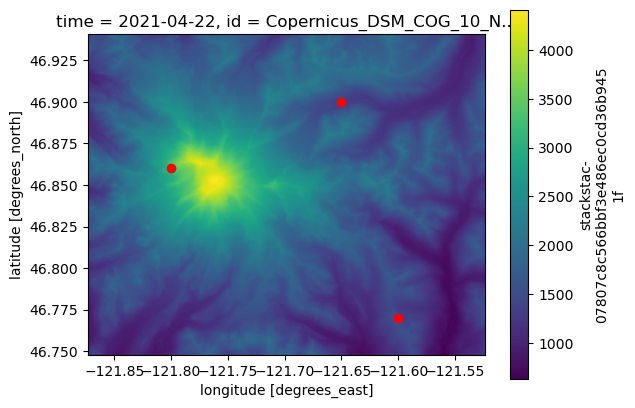

In [32]:
# plot the dem, with our point locations in red
f,ax = plt.subplots()
dem_rainier.plot(ax = ax)
points.plot(ax = ax, color = "red")

## Try to bring in my own NET CDF file

In [38]:
### Try importing a net cdf file
#import netCDF4
nc = xr.open_dataset("snod_2019_02.nc")

In [37]:
nc

<xarray.Dataset>
Dimensions:  (Time: 28, south_north: 1851, east_west: 1357)
Coordinates:
  * Time     (Time) datetime64[ns] 2019-02-01T03:00:00 ... 2019-02-28T03:00:00
    XLAT     (south_north, east_west) float32 ...
    XLONG    (south_north, east_west) float32 ...
Dimensions without coordinates: south_north, east_west
Data variables:
    snod     (Time, south_north, east_west) float32 ...
Attributes:
    units:          meters
    standard_name:  snow depth

In [204]:
#nc['Long'] = nc.XLONG
#nc['Lat']  = nc.XLAT

In [39]:
nc1d = nc.sel(Time = "2019-02-05")#.squeeze() # simplify to flat layer

In [222]:
#nc1d["snod"].plot() # plot, but coords are weird

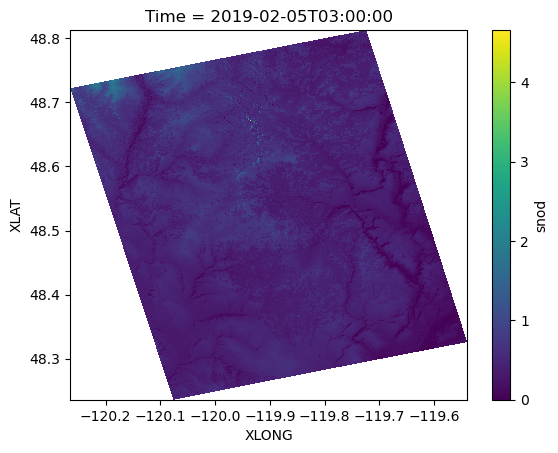

In [40]:
#nc1d["snod"].plot(y = "south_north", x="east_west") # plot snowdepth
nc1d["snod"].plot(y = "XLAT", x="XLONG") # plot snowdepth on lat/long coords

In [209]:
# but still the problem that the dimensions are not assigned 

In [43]:
x2 = [-120.0, -119.9]
y2 = [48.6, 48.4]
pts_geoms = gpd.points_from_xy(x = x2, y = y2)
pts = gpd.GeoDataFrame(geometry = pts_geoms, crs = 'EPSG:4326')


<Axes: title={'center': 'Time = 2019-02-05T03:00:00'}, xlabel='XLONG', ylabel='XLAT'>

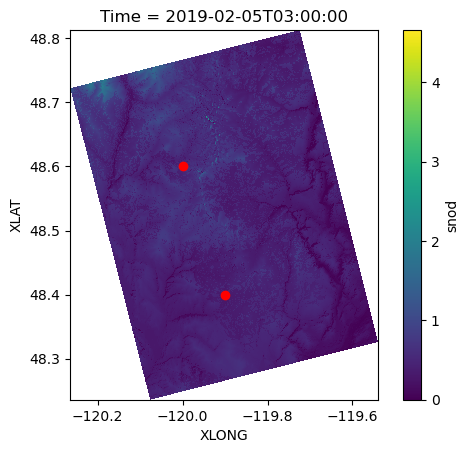

In [225]:
f,ax = plt.subplots()
nc1d["snod"].plot(y = "XLAT", x="XLONG", ax = ax)
pts2.plot(ax = ax, color = "red")
